NOTE:

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Under `Hardware accelerator`.
1. Select `T4 GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

#Activity 2- Creating a GAN for generating fake handwritten digits

**Note**: this is just a reference code to run and see how to create a mini GAN

By using TF-GAN's GAN Estimator and the MNIST dataset to quickly train a GAN.

**MNIST Data set**- dataset with 10k + handwritten digits, We'll use these images to train a GAN to generate fake images of handwritten digits.

**GAN Estimator**- TensorFlow's Estimator API that makes it easy to train models, GANEstimator is for training GANs

In [ ]:
import tensorflow.compat.v1 as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#Allows matplotlib images to render immediately.
tf.logging.set_verbosity(tf.logging.ERROR)
# Disable noisy outputs.

In [ ]:
#setting up the input pipeline ie the function that gives input to the GAN model with correct formatting
import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)

  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))

  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


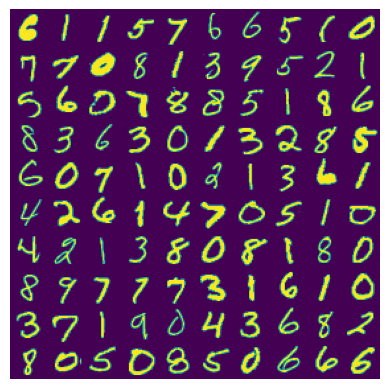

In [ ]:
#this is what the input data looks like
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

In [ ]:
#building generator and discriminator networks - neural networks
def _dense(inputs, units, l2_weight):
  return tf.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride],
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride],
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [ ]:
#generator fn
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)

  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)

  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)

  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [ ]:
#discriminator fn
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)

  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)

  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)

  net = tf.layers.flatten(net)

  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)

  net = _dense(net, 1, weight_decay)

  return net

In [ ]:
#evaluating GAN
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

In [ ]:
#training
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

<ipython-input-5-efc1e28ef953>:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
<ipython-input-5-efc1e28ef953>:10: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.layers.batch_normalization(
<ipython-input-5-efc1e28ef953>:14: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  return tf.layers.conv2d_transpose(
<ipython-input-5-efc1e28ef953>:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  return tf.layers.conv2d(
<ipython-i

Time since start: 0.33 min
Trained from step 0 to 500 in 25.27 steps / sec
Average discriminator output on Real: -12.07  Fake: -10.60
Inception Score: 6.15 / 8.35  Frechet Distance: 75.02


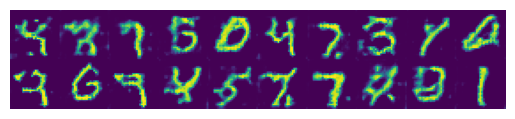

Time since start: 0.84 min
Trained from step 500 to 1000 in 27.91 steps / sec
Average discriminator output on Real: -10.46  Fake: -10.55
Inception Score: 6.66 / 8.35  Frechet Distance: 68.36


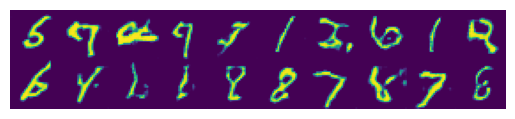

Time since start: 1.27 min
Trained from step 1000 to 1500 in 29.87 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ef90c62d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: -16.35  Fake: -17.04
Inception Score: 7.13 / 8.35  Frechet Distance: 56.31


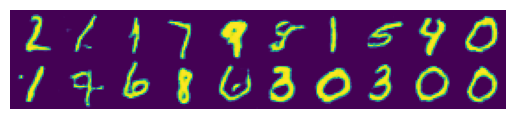

Time since start: 1.74 min
Trained from step 1500 to 2000 in 27.83 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ef8473f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: -19.66  Fake: -20.50
Inception Score: 7.22 / 8.35  Frechet Distance: 58.81


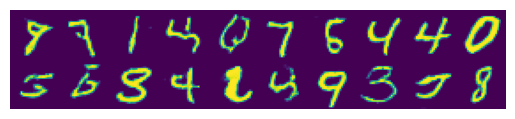

Time since start: 2.18 min
Trained from step 2000 to 2500 in 29.17 steps / sec
Average discriminator output on Real: 26.01  Fake: 20.78
Inception Score: 7.24 / 8.35  Frechet Distance: 58.96


Exception ignored in: <generator object Estimator.predict at 0x7b7eea30ab20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


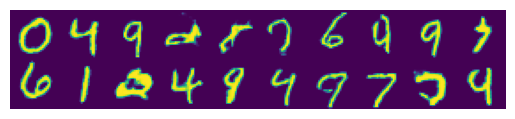

Time since start: 2.62 min
Trained from step 2500 to 3000 in 29.05 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ed9b8a420>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: 23.77  Fake: 19.03
Inception Score: 7.28 / 8.35  Frechet Distance: 57.31


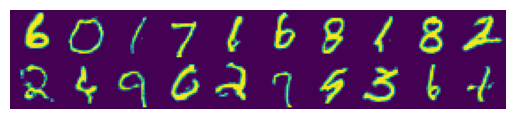

Time since start: 3.04 min
Trained from step 3000 to 3500 in 29.92 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ef81ca810>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: 52.71  Fake: 48.26
Inception Score: 7.38 / 8.35  Frechet Distance: 59.77


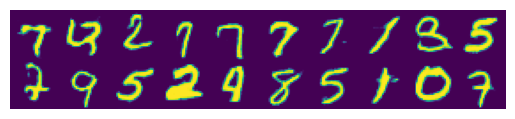

Time since start: 3.46 min
Trained from step 3500 to 4000 in 29.92 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ef810bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: 90.00  Fake: 87.86
Inception Score: 7.34 / 8.35  Frechet Distance: 56.04


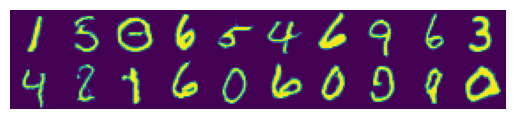

Time since start: 3.90 min
Trained from step 4000 to 4500 in 29.79 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ed98c6b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: 14.34  Fake: 4.23
Inception Score: 7.35 / 8.35  Frechet Distance: 57.81


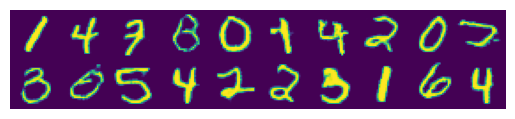

Time since start: 4.36 min
Trained from step 4500 to 5000 in 28.09 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7b7ed8cf2260>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Average discriminator output on Real: 144.57  Fake: 133.62
Inception Score: 7.43 / 8.35  Frechet Distance: 58.72


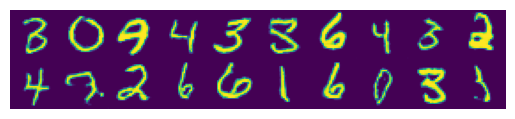

In [ ]:
#Training and seeing the results-
# NOTE: this step can take from 10-20 mins
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step

  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))

  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()

